## Imports

In [1]:
# Torch
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# General
import matplotlib
import numpy as np

## Dataset

### Config

In [2]:
CLASSES = 10

### Preparation

In [3]:
# Load dataset
test_set = dsets.MNIST(root='./data', train=False, download=True)
train_set = dsets.MNIST(root='./data', train=True, download=True)

In [4]:
# Data as numpy
test_data = test_set.data.numpy()
train_data = train_set.data.numpy()

# Labels as numpy
test_labels = test_set.targets.numpy()
train_labels = train_set.targets.numpy()

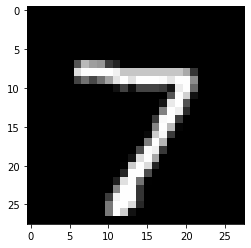

In [5]:
# Plot sample data
import matplotlib.pyplot as plt
%matplotlib inline

img = test_data[0]
plt.imshow(img, cmap='gray')

In [6]:
# Flatten train and test data
test_flattened = test_data.reshape((test_data.shape[0], 784))
train_flattened = train_data.reshape((train_data.shape[0], 784))

print("Test shape (flattened): ", test_flattened.shape)
print("Train shape (flattened): ", train_flattened.shape)

# Extend test flattened dataset to include the bias
test_flattened = np.hstack((test_flattened,np.ones((10000,1))))

Test shape (flattened):  (10000, 784)
Train shape (flattened):  (60000, 784)


In [7]:
# One hot encoding
one_hot_test = np.eye(CLASSES)[test_labels]
one_hot_train = np.eye(CLASSES)[train_labels]

print("Test labels: ", one_hot_test.shape)
print("Train labels: ", one_hot_train.shape)

Test labels:  (10000, 10)
Train labels:  (60000, 10)


## Network

### Config

In [8]:
BATCH = 20
HIDDEN = 15
DEBUG = False
EPSILON = 0.005
EPOCHS = 200 * 3000 # 5 passes over data

### Routines

In [9]:
def mse(y, target,deriv = False):
    if deriv:
        return 2*(target - y)
    return np.sum(np.square(target - y))

# Sigmoid function for the
# activation between input
# and hidden layer, as well
# as hidden to output layer
# activation
def sigmoid(x, deriv=False):
    if(deriv == True):
        return x*(1-x)
    
    return 1/(1+np.exp(-x))

# Softmax activation function
# to normalize the output as
# a vector of probabilities
# for every single possible
# class
def softmax(x, deriv=False):
    if(deriv == True):
        return x*(1-x)

    x = x - x.max(axis=1, keepdims=True)
    y = np.exp(x)
    sigma = y / y.sum(axis=1, keepdims=True)
    return sigma

# Feed forward operation
def feed_forward(input_batch, w1, w2):
    # Dot products
    a1 = sigmoid(np.dot(input_batch,w1))
    a1 = np.hstack((a1,np.ones((input_batch.shape[0],1))))
    #print(a1.shape)
    a2 = softmax(np.dot(a1,w2))
    
    return input_batch, a1, a2

# Evaluate learnt weights
def evaluate(test, w1, w2, labels):
    # Metrics
    corrects, wrongs = 0, 0
    
    # Evaluate on test set
    for i in range(len(test)):
        # Add dimension
        data = np.array([test[i]])
        
        # Run feedforward
        _, _, res = feed_forward(data, w1, w2)
        
        # Check result
        res_max = res.argmax()
        if res_max == labels[i]:
            corrects += 1
        else:
            wrongs += 1
            
    return corrects, wrongs

def confusion_matrix(test_data, w1, w2, labels):
        # Confusion matrix
        cm = np.zeros((10, 10), int)
        
        for i in range(len(test_data)):
            # Test sample
            data = np.array([test_data[i]])
            
            # Get result
            _, _, res = feed_forward(data, w1, w2)
            res_max = res.argmax()
            target = labels[i]
            cm[res_max, int(target)] += 1
            
        return cm  

### Training

In [10]:
# Fix random seed
np.random.seed(1)

# Weights
w1 = 2 * np.random.random((784, HIDDEN)) - 1
w2 = 2 * np.random.random((HIDDEN, 10)) - 1
# Biases
b0 = np.zeros((1,HIDDEN))
b1 = np.zeros((1,10))


# Biases with weights 
w1 = np.vstack((w1,b0))
w2 = np.vstack((w2,b1))

for epoch in range(EPOCHS):
    # Index
    idx = epoch % 3000
    
    # Feed forward process
    input_batch = train_flattened[(idx * BATCH):((idx + 1) * BATCH), :]
    input_batch = np.hstack((input_batch,np.ones((20,1))))
    #print(input_batch.shape) 
    a0, a1, a2 = feed_forward(input_batch, w1, w2)
    
    if DEBUG:
        print("A0 shape: ", a0.shape)
        print("A1 shape: ", a1.shape)
        print("A2 shape: ", a2.shape)
    
    # Compute mean error
    y = one_hot_train[(idx * BATCH):((idx + 1) * BATCH), :]
    
    # Print MSE
    if (epoch % 10000) == 0:
        print("MSE: ", mse(a2,y))
    
    if DEBUG:
        print("Error shape: ", error)
        
    # Compute DELTA2
    delta2 = (a2 - y) * softmax(a2, True)
    
    # Compute dw2
    dw2 = np.dot(a1.T, delta2)
    
    
    # Compute DELTA1
    delta1 = np.dot(delta2, w2.T) * sigmoid(a1, True)
    
    dw1 = np.dot(a0.T, delta1[:,0:-1])
    #print("dw2 shape",dw1.shape)
    
    
    if DEBUG:
        print("DELTA2 shape: ", delta2.shape)
        print("dW2 shape: ", dw2.shape)
        print("DELTA1 shape: ", delta1.shape)
        print("dW1 shape: ", dw1.shape)
        
    
    
    # Update weights
    w2 -= (EPSILON * dw2)
    w1 -= (EPSILON * dw1)
    

/Users/dailand10/opt/miniconda3/envs/cvl/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


MSE:  18.69965245733769
MSE:  11.824162153357367
MSE:  7.332570112496555
MSE:  5.085122774456567
MSE:  7.4516975887444135
MSE:  5.333856386716547
MSE:  4.092602348595648
MSE:  5.835051937785297
MSE:  5.422307117828904
MSE:  1.920589191559697
MSE:  5.3847674910890415
MSE:  3.5777105622243766
MSE:  1.8300644305921057
MSE:  5.441772049476711
MSE:  5.321014577524788
MSE:  1.3998511493675068
MSE:  7.2740959349329355
MSE:  3.4910106924420994
MSE:  2.4117636237027975
MSE:  7.247346106403179
MSE:  4.03965497618214
MSE:  3.6486487413532225
MSE:  6.104541250937869
MSE:  3.525020895268359
MSE:  0.7435146673488878
MSE:  7.028462027213054
MSE:  5.625381717493946
MSE:  0.6400832349695349
MSE:  6.121722331003082
MSE:  3.3728577729784757
MSE:  1.7631003751558143
MSE:  4.846129580485353
MSE:  4.534481478245169
MSE:  1.9016910381498706
MSE:  6.7155367235845524
MSE:  3.378454981990907
MSE:  4.178673627795951
MSE:  3.2241684528110266
MSE:  3.6914683885516126
MSE:  0.7930271751041436
MSE:  2.91870614453665

## Evaluation

### Accuracy

In [11]:
c, w = evaluate(test_flattened, w1, w2, test_labels)

/Users/dailand10/opt/miniconda3/envs/cvl/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [12]:
print("The model accuracay is: ", c / (c + w))

The model accuracay is:  0.8906


### Confusion Matrix

In [13]:
cm = confusion_matrix(test_flattened, w1, w2, test_labels)

/Users/dailand10/opt/miniconda3/envs/cvl/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [14]:
cm

array([[ 917,    0,   10,    2,    0,   24,   17,    5,   13,    2],
       [   0, 1072,    3,    1,    5,    7,    3,   14,    4,    6],
       [   5,    2,  873,   20,    6,    8,   11,   24,   14,    2],
       [   4,   16,   42,  910,    2,   46,    0,    5,   33,   13],
       [   4,    0,   20,    1,  866,   11,    7,    4,   14,   28],
       [   8,    2,    8,   38,    3,  723,    6,    0,   11,   19],
       [  18,    2,   17,    2,   17,   22,  890,    1,   17,    7],
       [   4,   22,   12,   13,    1,    2,    1,  932,   14,   42],
       [  11,   19,   45,   18,   10,   42,   16,    7,  841,    8],
       [   9,    0,    2,    5,   72,    7,    7,   36,   13,  882]])